In [1]:
import pandas as pd
import re

## Armado de dataset para entrenamiento del modelo

Se usan ventanas de tiempo de 6 meses para agrupar los datos y predecir la baja. 

Training: 
- 1 a 6
- 2 a 7
- 3 a 8
- 4 a 9
- 5 a 10
- 6 a 11

Optimization
- 7 a 12

Validation
- 8 a 13

Test
- 9 a 14
- 10 a 15

In [2]:
df = pd.read_feather('../../../../data/processed/merged_18_periods(BPICS).feather')

### Detectamos inconsistencias: Del periodo 1 a 3 no hay cargados valores para SITUACION_PP

<h4 style="color:red" > Se soluciona agregando las columnas al dataframe lleno de nulls. REVISAR EL SCRIPT ORIGINAL A FUTURO</h4>

In [5]:
import numpy as np

for col in ['1_SITUACION_PP','2_SITUACION_PP','3_SITUACION_PP']:
    df[col] = np.nan

In [6]:
sini_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d_TIPO_SINI', col)]].columns])

In [10]:
for col in sini_cols:
    for i in range(1,15):
        if f'{i}{col}' not in df.columns:
            df[f'{i}{col}'] = np.nan

### Script de agrupación de registros de acuerdo a las ventanas temporales. El test está en *1. Test to arrange datasets by time periods*

In [11]:
# Buscamos las features que son periódicas
periodic_cols = set([''.join([s for s in col if not s.isdigit()]) for col in df[[col for col in df.columns if re.search(f'\d', col)]].columns])

# Armamos otro dataframe con todas las features que no son temporales
non_periodic_df = df[[col for col in df.columns if not any(char.isdigit() for char in col)]]

# Definimos ventana inicial
w_low = 1
w_top = 6

final_df = pd.DataFrame()

while(w_low < 11):
    print(f"----------TIME WINDOW: {w_low} a {w_top}-----------")
    # Armamos todo el nuevo dataset del periodo en grouped_df
    grouped_df = non_periodic_df.copy(deep=True)

    #Seleccionamos las features del periodo
    print("Seleccionando features por periodo...                       ", end="\r", flush=True)
    for pcol in periodic_cols:
        regex_range = "|".join([str(i) for i in range(w_low, w_top+1)])
        regex = f'{pcol}({regex_range})$|^({regex_range}){pcol}'
        columns = [col for col in df.columns if re.search(regex, col)]
        grouped_df[[f"{i}_{pcol}" for i in range(6, 0, -1)]] = df[columns]

    # Buscamos los clientes que no tienen polizas en el periodo analizado
    print("Buscando clientes sin polizas...                       ", end="\r", flush=True)
    grouped_df = grouped_df[grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float).sum(axis=1) > 0]
    
    # Buscamos las polizas que ya se dieron de baja en el periodo analizado
    print("Buscando clientes que ya se dieron de baja...                  ", end="\r", flush=True)
    grouped_df = grouped_df[~grouped_df["periodo_baja"].between(1, w_top + 2)]

    # Preparamos columnas de pólizas por período
    print("Preparando pólizas por períodos...                             ", end="\r", flush=True)
    grouped_df[[f"polizas_{i}" for i in range(6, 0, -1)]] = grouped_df["hist_polizas"].str.split(" ", expand=True).iloc[:,w_low-1:w_top].astype(float)
    
    # Calculamos campos adicionales (Diferencias entre periodos)
    print("Preparando campos adicionales...                             ", end="\r", flush=True)
    for i in range(5, 0, -1):
        grouped_df[f"diff_cant_polizas_{i}"] = grouped_df[f"polizas_{i}"] - grouped_df[f"polizas_{i+1}"]    
        current_int = [col for col in grouped_df.columns if re.search(f'({i})__TIPOINT', col)]
        next_int = [col for col in grouped_df.columns if re.search(f'({i+1})__TIPOINT', col)]
        grouped_df[f"diff_cant_int_{i}"] =  grouped_df[current_int].sum(axis=1) - grouped_df[next_int].sum(axis=1)
        
    # Marcamos aquellos que se dieron de baja a los tres meses del periodo analizado
    print("Creando flag de baja...")
    grouped_df["BAJA_3m"] = grouped_df["periodo_baja"] == (w_top + 3)

    # Marcamos un flag para saber la ventana de tiempo que se analiza
    print("Creando flag de periodo...                        ", end="\r", flush=True)
    grouped_df["time_window"] = f"{w_low} a {w_top}"

    # Agregamos el tipo de dataset 
    if(w_low < 7):
        grouped_df["dataset"] = 'train'
    elif(w_low == 7):
        grouped_df["dataset"] = 'opt'
    elif(w_low == 8):
        grouped_df["dataset"] = 'val'
    else:
        grouped_df["dataset"] = 'test'
    
    # Agregamos el periodo al datafame final 
    final_df = pd.concat([final_df, grouped_df], ignore_index=True)
    
    del grouped_df
    w_low += 1
    w_top += 1
    print("Next window...")
    
del non_periodic_df
del df
print("Ready!")

----------TIME WINDOW: 1 a 6-----------
Creando flag de baja...onales...                               
Next window...e periodo...                        
----------TIME WINDOW: 2 a 7-----------
Creando flag de baja...onales...                               
Next window...e periodo...                        
----------TIME WINDOW: 3 a 8-----------
Creando flag de baja...onales...                               
Next window...e periodo...                        
----------TIME WINDOW: 4 a 9-----------
Creando flag de baja...onales...                               
Next window...e periodo...                        
----------TIME WINDOW: 5 a 10-----------
Creando flag de baja...onales...                               
Next window...e periodo...                        
----------TIME WINDOW: 6 a 11-----------
Creando flag de baja...onales...                               
Next window...e periodo...                        
----------TIME WINDOW: 7 a 12-----------
Creando flag de baja...onal

In [ ]:
final_df

In [ ]:
final_df[final_df["CIF_ID"]==1429.0]

Una vez verificados los datos, eliminamos las columnas que no se van a usar más

In [12]:
final_df = final_df.drop(["CIF_ID","hist_polizas","periodo_baja"], axis=1)

In [13]:
final_df["BAJA_3m"].value_counts(normalize=True)

False    0.978585
True     0.021415
Name: BAJA_3m, dtype: float64

In [14]:
final_df[final_df["BAJA_3m"]]["time_window"].value_counts().sort_index().plot.bar()

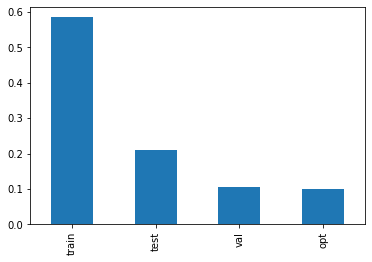

In [15]:
final_df[final_df["BAJA_3m"]]["dataset"].value_counts(normalize=True).plot.bar()

## Guardamos los datsets

### Train

In [17]:
final_df[final_df['dataset'] == 'train'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/3m_train_set.feather")

### Opt

In [18]:
final_df[final_df['dataset'] == 'opt'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/3m_optimization_set.feather")

### Val

In [19]:
final_df[final_df['dataset'] == 'val'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/3m_validation_set.feather")

### Test

In [20]:
final_df[final_df['dataset'] == 'test'].drop(columns='dataset').reset_index(drop=True).to_feather("../../../../data/processed/3m_test_set.feather")